In [1]:
# install dependencies: 
#!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu102 False
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#import torch
#assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
#For multiple classes
def getKey(dictionary):
    keys = list(dictionary.keys())
    values = list(dictionary.values())
    index = 0
    while (index < len(values)):
        if int(values[index]) == 1:
            key = keys[index]
            return int(key[-1]) - 1
        else:
            index+=1
    return -1 
#An error should occur if we reach this ^

In [5]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

path = "raw/"

def get_cars_dict(img_dir, fileName):
    json_file = os.path.join(img_dir, fileName)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            classes = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                # "category_id": getKey(classes), # for mutiple classes
                "category_id": 0, # for single class
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

d = "train"
DatasetCatalog.register("damage_train", lambda d=d: get_cars_dict(path, "data_polygon_51.json"))
#MetadataCatalog.get("damage_train").thing_classes=["damage1", "damage2", "damage3"]
MetadataCatalog.get("damage_train").thing_classes=["damage"]
train_metadata = MetadataCatalog.get("damage_train")

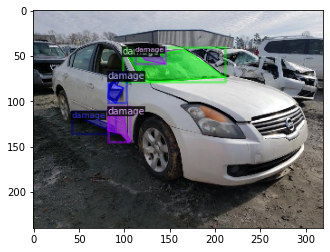

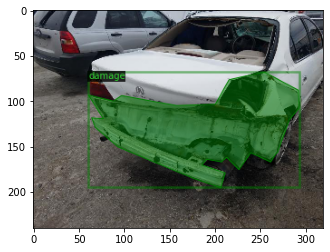

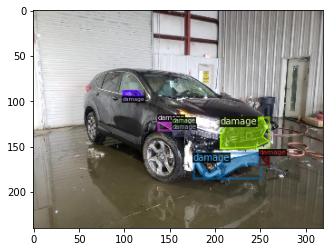

In [6]:
dataset_dicts = get_cars_dict(path, "data_polygon_51.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #plt.figure(figsize = (10, 10))
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu" #only if GPU not available
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("damage_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 200    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.INPUT.MIN_SIZE_TRAIN = (256, 256)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/02 10:12:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/02 10:12:46 d2.data.build]: Removed 0 images with no usable annotations. 25 images left.
[07/02 10:12:46 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   damage   | 95           |
|            |              |
[07/02 10:12:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(256, 256), max_size=1333, sample_style='choice'), RandomFlip()]
[07/02 10:12:46 d2.data.build]: Using training sampler TrainingSampler
[07/02 10:12:46 d2.data.common]: Serializing 25 elements to byte tensors and concatenating them all ...
[07/02 10:12:46 d2.data.common]: Serialized dataset takes 0.03 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[07/02 10:12:56 d2.engine.train_loop]: Starting training from iteration 0
[07/02 10:18:11 d2.utils.events]:  eta: 0:45:44  iter: 19  total_loss: 2.388  loss_cls: 0.5494  loss_box_reg: 0.168  loss_mask: 0.6933  loss_rpn_cls: 0.8598  loss_rpn_loc: 0.1212  time: 15.0872  data_time: 0.1255  lr: 4.9952e-05  
[07/02 10:23:25 d2.utils.events]:  eta: 0:40:39  iter: 39  total_loss: 1.663  loss_cls: 0.2968  loss_box_reg: 0.2362  loss_mask: 0.6818  loss_rpn_cls: 0.3442  loss_rpn_loc: 0.1033  time: 15.4091  data_time: 0.0301  lr: 9.9902e-05  


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_dicts = get_cars_dict(path, "data_polygon_51.json")

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata = train_metadata, scale = 0.5)
    original = v.draw_dataset_dict(d)
    plt.figure(figsize = (40, 40))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1], metadata = train_metadata, scale = 0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    
    plt.show()
